# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

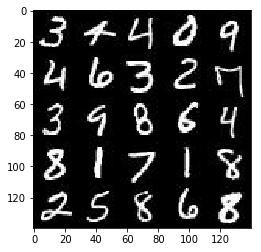

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

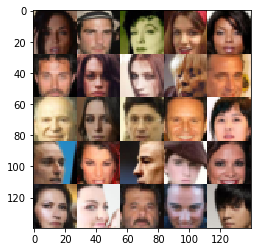

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[-show_n_images:], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="real_input")
    z_input = tf.placeholder(tf.float32, shape=(None,z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return real_input , z_input ,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    
    with tf.variable_scope("discriminator",reuse=reuse) :
        
        
        ## Layer 1  : Input layer is 28x28x3
        ip_layer = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        ip_leaky_relu = tf.maximum(alpha * ip_layer, ip_layer)
        ip_leaky_relu = tf.layers.dropout(ip_leaky_relu,rate=0.2,training=True)
        # 14x14x64
        
        ## Layer 2 
        conv_layer_1 = tf.layers.conv2d(ip_leaky_relu, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),use_bias=False)
        bn_layer_1 = tf.layers.batch_normalization(conv_layer_1, training=True)
        conv_layer_1_leaky_relu = tf.maximum(alpha * bn_layer_1, bn_layer_1)
        
        # 7x7x128
        
        ## Layer 3 
        conv_layer_2 = tf.layers.conv2d(conv_layer_1_leaky_relu, 256, 5, strides=1, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),use_bias=False)
        bn_layer_2 = tf.layers.batch_normalization(conv_layer_2, training=True)
        conv_layer_2_leaky_relu = tf.maximum(alpha * bn_layer_2, bn_layer_2)
        conv_layer_2_leaky_relu = tf.layers.dropout(conv_layer_2_leaky_relu,rate=0.2,training=True)

        # 7x7x256
              
        # Flatten it
        flat = tf.reshape(conv_layer_2_leaky_relu, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))

        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim,is_train=True,beta1=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope("generator",reuse=not is_train) :
        
        ## First fully connected layer
        ip_layer = tf.layers.dense(z, 7*7*128, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        ip_bn_layer = tf.layers.batch_normalization(ip_layer, training=is_train)
        # Reshape it to start the convolutional stack
        ip_layer = tf.reshape(ip_bn_layer ,(-1, 7, 7, 128))
        ip_leaky_relu = tf.maximum(alpha * ip_layer, ip_layer)
        ip_leaky_relu = tf.layers.dropout(ip_leaky_relu,rate=0.2,training=is_train)

        # 7x7x512 now
                    
        ## Layer 1
        conv_layer_1 = tf.layers.conv2d_transpose(ip_leaky_relu, 128, 5, strides=2, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),use_bias=False)
        bn_layer_1 = tf.layers.batch_normalization(conv_layer_1, training=is_train)
        conv_layer_1_leaky_relu = tf.maximum(alpha * bn_layer_1, bn_layer_1)
        # 14x14x256 now
        
        ## Layer 2
        conv_layer_2 = tf.layers.conv2d_transpose(conv_layer_1_leaky_relu, 64, 5, strides=2, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),use_bias=False)
        bn_layer_2 = tf.layers.batch_normalization(conv_layer_2, training=is_train)
        conv_layer_2_leaky_relu = tf.maximum(alpha * bn_layer_2, bn_layer_2)
        conv_layer_2_leaky_relu = tf.layers.dropout(conv_layer_2_leaky_relu,rate=0.2,training=is_train)

        # 28x28x128 now
                  
        ## Layer 3
        logits = tf.layers.conv2d_transpose(conv_layer_2_leaky_relu,out_channel_dim ,5,strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xOUT_CHANNEL_DIM now
                       
        out = tf.tanh(logits)
        
        return out
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
        
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real) * 0.8))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer( learning_rate,  beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [34]:
from time import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # set Tensorboard logging dir
    logging_path = "/tmp/tensorflow/face-gen/logs/{}".format(time())
    
    # parse input parameters
    width, height, channel = data_shape[1], data_shape[2], data_shape[3]
    
    # get model tensors
    input_real, input_z, learn_rate = model_inputs(width, height, channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    # create model saver object
    saver = tf.train.Saver()
    
    # create a summary for our cost and accuracy
    tf.summary.scalar("discriminator_loss", d_loss)
    tf.summary.scalar("generator_loss", g_loss)
    
    # merge all summaries into a single "operation" which we can execute in a session 
    summary_op = tf.summary.merge_all()
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # create log writer object
        writer = tf.summary.FileWriter(logging_path,sess.graph,filename_suffix="log",flush_secs=2)
        
        #new_saver = tf.train.import_meta_graph('./generator.ckpt.meta')
        #new_saver.restore(sess, tf.train.latest_checkpoint('./'))
        init_time = time()
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images *2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                if steps / 2 == 1.0 :
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                # Run summary generation
                summary = sess.run(summary_op, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                # write log
                writer.add_summary(summary,steps)
                
                if steps % 100 == 0:
                    final_time = time()
                    time_taken = final_time - init_time
                    init_time =time()
                    # print the losses every 100 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}..., step {}\n".format(epoch_i+1, epochs, steps),
                          "Time Taken for {} steps : {:.2f}\n".format(100,time_taken),
                          "Discriminator Loss: {:.4f}...\n".format(train_loss_d),
                          "Generator Loss: {:.4f}\n".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, channel, data_image_mode)
                    
            saver.save(sess, './generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

batch size : 16
z_dim : 100
learning_rate : 0.0007
beta1 : 0.25
Epoch 1/2..., step 100
 Time Taken for 100 steps : 6.01
 Discriminator Loss: 3.1333...
 Generator Loss: 3.9529



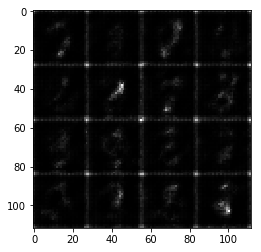

Epoch 1/2..., step 200
 Time Taken for 100 steps : 5.99
 Discriminator Loss: 1.3454...
 Generator Loss: 1.7483



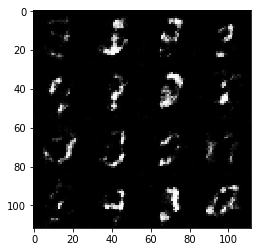

Epoch 1/2..., step 300
 Time Taken for 100 steps : 5.81
 Discriminator Loss: 1.8202...
 Generator Loss: 2.1727



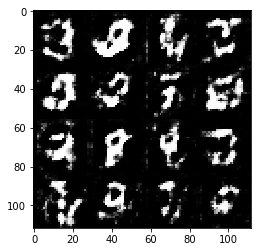

Epoch 1/2..., step 400
 Time Taken for 100 steps : 5.83
 Discriminator Loss: 1.7976...
 Generator Loss: 0.6446



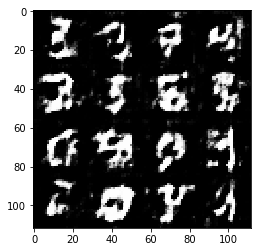

Epoch 1/2..., step 500
 Time Taken for 100 steps : 5.84
 Discriminator Loss: 1.3640...
 Generator Loss: 0.8227



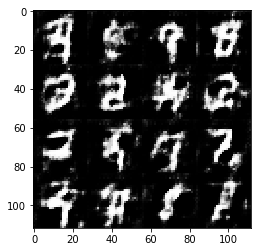

Epoch 1/2..., step 600
 Time Taken for 100 steps : 5.86
 Discriminator Loss: 1.7268...
 Generator Loss: 2.5991



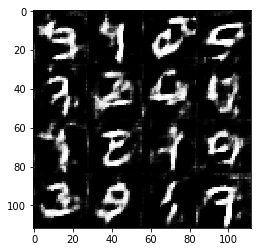

Epoch 1/2..., step 700
 Time Taken for 100 steps : 5.84
 Discriminator Loss: 1.2477...
 Generator Loss: 1.2835



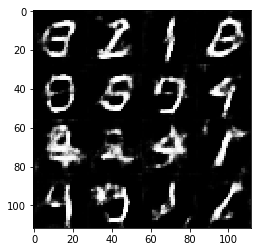

Epoch 1/2..., step 800
 Time Taken for 100 steps : 5.83
 Discriminator Loss: 1.0985...
 Generator Loss: 0.9736



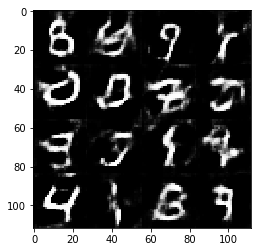

Epoch 1/2..., step 900
 Time Taken for 100 steps : 5.84
 Discriminator Loss: 2.2240...
 Generator Loss: 0.3260



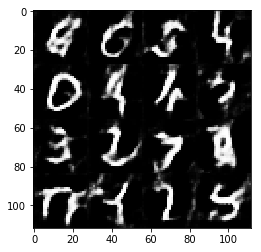

Epoch 1/2..., step 1000
 Time Taken for 100 steps : 5.84
 Discriminator Loss: 1.8232...
 Generator Loss: 0.4001



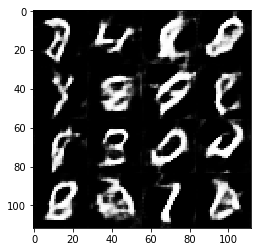

Epoch 1/2..., step 1100
 Time Taken for 100 steps : 5.85
 Discriminator Loss: 1.2913...
 Generator Loss: 1.2914



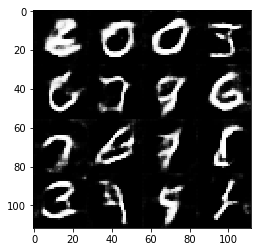

Epoch 1/2..., step 1200
 Time Taken for 100 steps : 5.87
 Discriminator Loss: 1.3166...
 Generator Loss: 0.8038



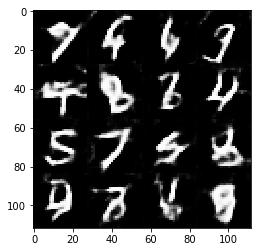

Epoch 1/2..., step 1300
 Time Taken for 100 steps : 5.83
 Discriminator Loss: 1.3808...
 Generator Loss: 0.7250



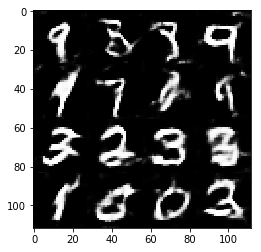

Epoch 1/2..., step 1400
 Time Taken for 100 steps : 6.11
 Discriminator Loss: 1.0644...
 Generator Loss: 1.6659



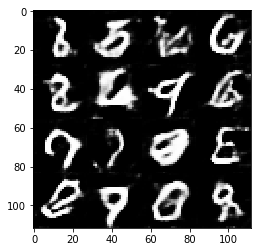

Epoch 1/2..., step 1500
 Time Taken for 100 steps : 5.96
 Discriminator Loss: 1.3923...
 Generator Loss: 0.7254



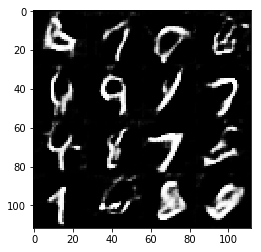

Epoch 1/2..., step 1600
 Time Taken for 100 steps : 5.98
 Discriminator Loss: 1.2130...
 Generator Loss: 2.3297



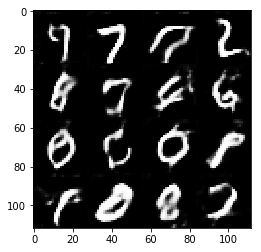

Epoch 1/2..., step 1700
 Time Taken for 100 steps : 5.93
 Discriminator Loss: 1.5492...
 Generator Loss: 0.6947



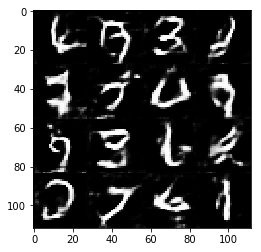

Epoch 1/2..., step 1800
 Time Taken for 100 steps : 6.14
 Discriminator Loss: 1.0120...
 Generator Loss: 1.7433



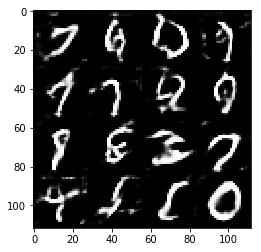

Epoch 1/2..., step 1900
 Time Taken for 100 steps : 6.27
 Discriminator Loss: 1.0639...
 Generator Loss: 1.7561



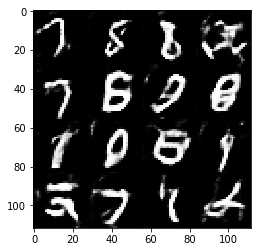

Epoch 1/2..., step 2000
 Time Taken for 100 steps : 6.02
 Discriminator Loss: 1.4784...
 Generator Loss: 0.6593



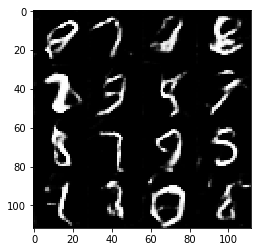

Epoch 1/2..., step 2100
 Time Taken for 100 steps : 6.00
 Discriminator Loss: 1.4423...
 Generator Loss: 2.4214



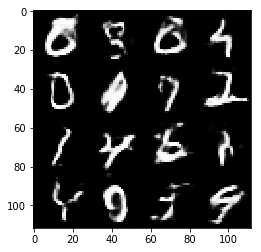

Epoch 1/2..., step 2200
 Time Taken for 100 steps : 6.02
 Discriminator Loss: 1.2870...
 Generator Loss: 0.9288



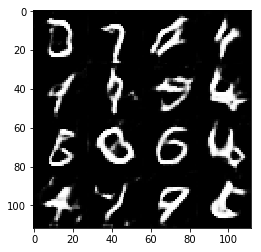

Epoch 1/2..., step 2300
 Time Taken for 100 steps : 6.09
 Discriminator Loss: 1.5539...
 Generator Loss: 2.5289



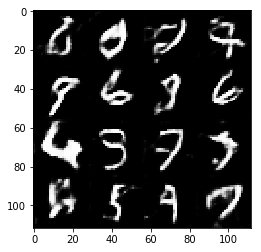

Epoch 1/2..., step 2400
 Time Taken for 100 steps : 6.16
 Discriminator Loss: 1.3151...
 Generator Loss: 0.7613



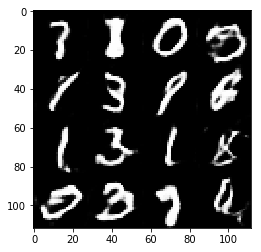

Epoch 1/2..., step 2500
 Time Taken for 100 steps : 6.06
 Discriminator Loss: 1.1004...
 Generator Loss: 1.7382



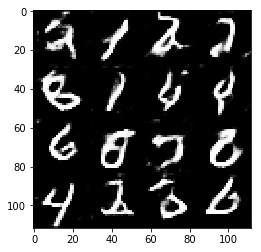

Epoch 1/2..., step 2600
 Time Taken for 100 steps : 8.37
 Discriminator Loss: 1.0807...
 Generator Loss: 1.1209



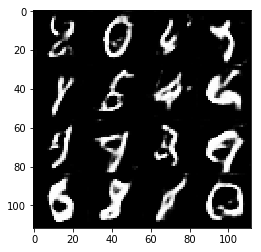

Epoch 1/2..., step 2700
 Time Taken for 100 steps : 5.91
 Discriminator Loss: 1.7406...
 Generator Loss: 0.5862



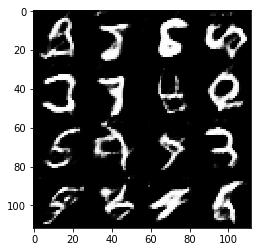

Epoch 1/2..., step 2800
 Time Taken for 100 steps : 6.18
 Discriminator Loss: 1.1059...
 Generator Loss: 1.2684



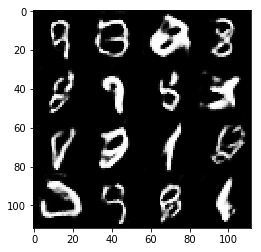

Epoch 1/2..., step 2900
 Time Taken for 100 steps : 6.09
 Discriminator Loss: 0.9013...
 Generator Loss: 2.1330



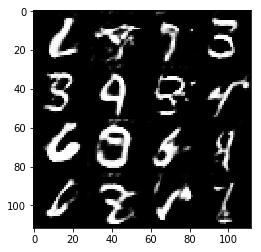

Epoch 1/2..., step 3000
 Time Taken for 100 steps : 5.91
 Discriminator Loss: 1.0100...
 Generator Loss: 1.2942



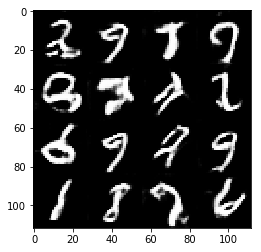

Epoch 1/2..., step 3100
 Time Taken for 100 steps : 5.90
 Discriminator Loss: 1.1704...
 Generator Loss: 1.3768



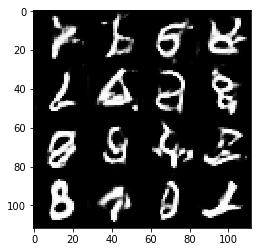

Epoch 1/2..., step 3200
 Time Taken for 100 steps : 6.03
 Discriminator Loss: 1.1274...
 Generator Loss: 2.0113



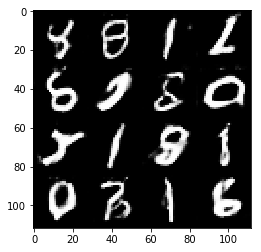

Epoch 1/2..., step 3300
 Time Taken for 100 steps : 6.22
 Discriminator Loss: 0.8683...
 Generator Loss: 2.0962



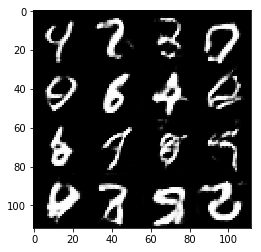

Epoch 1/2..., step 3400
 Time Taken for 100 steps : 6.19
 Discriminator Loss: 1.4359...
 Generator Loss: 0.7001



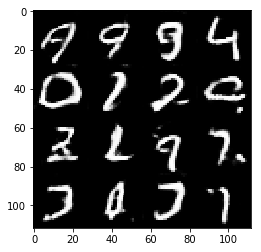

Epoch 1/2..., step 3500
 Time Taken for 100 steps : 6.15
 Discriminator Loss: 0.9665...
 Generator Loss: 1.8613



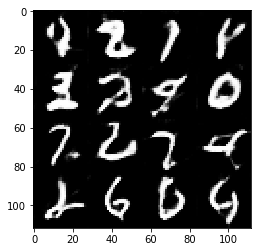

Epoch 1/2..., step 3600
 Time Taken for 100 steps : 6.33
 Discriminator Loss: 0.8461...
 Generator Loss: 1.9791



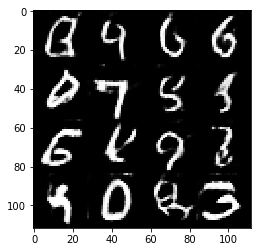

Epoch 1/2..., step 3700
 Time Taken for 100 steps : 6.05
 Discriminator Loss: 1.0092...
 Generator Loss: 1.2997



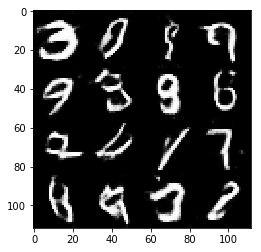

Epoch 2/2..., step 3800
 Time Taken for 100 steps : 6.55
 Discriminator Loss: 0.9880...
 Generator Loss: 1.3003



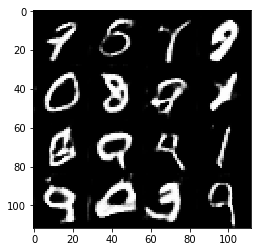

Epoch 2/2..., step 3900
 Time Taken for 100 steps : 5.89
 Discriminator Loss: 0.7453...
 Generator Loss: 2.1483



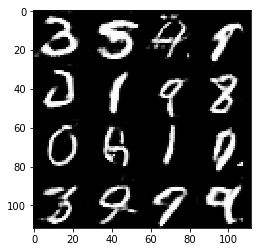

Epoch 2/2..., step 4000
 Time Taken for 100 steps : 5.91
 Discriminator Loss: 0.9089...
 Generator Loss: 1.5956



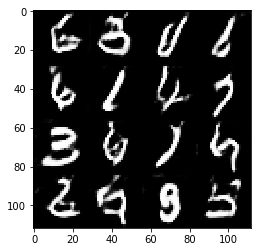

Epoch 2/2..., step 4100
 Time Taken for 100 steps : 5.87
 Discriminator Loss: 0.9155...
 Generator Loss: 1.5561



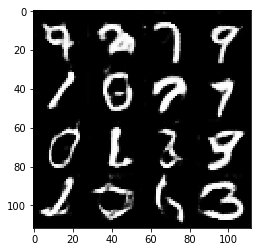

Epoch 2/2..., step 4200
 Time Taken for 100 steps : 5.91
 Discriminator Loss: 1.0976...
 Generator Loss: 1.3790



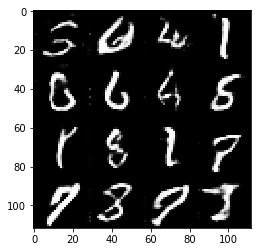

Epoch 2/2..., step 4300
 Time Taken for 100 steps : 5.89
 Discriminator Loss: 0.8197...
 Generator Loss: 1.4029



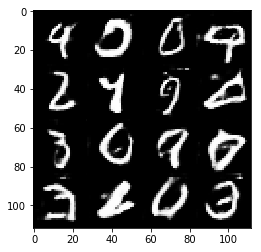

Epoch 2/2..., step 4400
 Time Taken for 100 steps : 5.89
 Discriminator Loss: 1.2115...
 Generator Loss: 1.1451



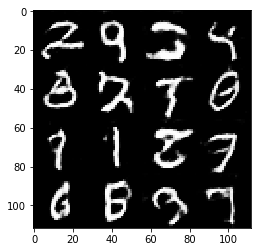

Epoch 2/2..., step 4500
 Time Taken for 100 steps : 5.90
 Discriminator Loss: 0.7707...
 Generator Loss: 1.9478



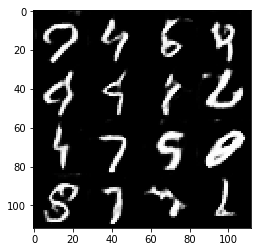

Epoch 2/2..., step 4600
 Time Taken for 100 steps : 5.88
 Discriminator Loss: 1.3352...
 Generator Loss: 1.0791



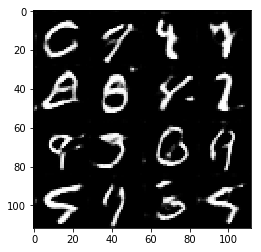

Epoch 2/2..., step 4700
 Time Taken for 100 steps : 5.93
 Discriminator Loss: 1.1921...
 Generator Loss: 0.7706



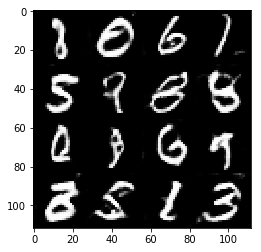

Epoch 2/2..., step 4800
 Time Taken for 100 steps : 5.97
 Discriminator Loss: 0.8920...
 Generator Loss: 1.2577



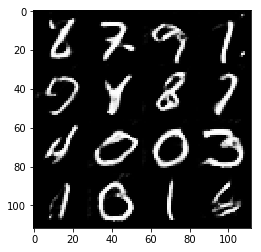

Epoch 2/2..., step 4900
 Time Taken for 100 steps : 6.13
 Discriminator Loss: 0.9744...
 Generator Loss: 1.9235



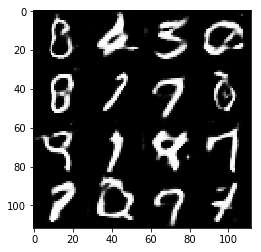

Epoch 2/2..., step 5000
 Time Taken for 100 steps : 6.12
 Discriminator Loss: 1.2333...
 Generator Loss: 1.2200



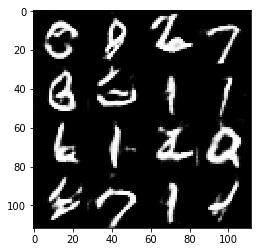

Epoch 2/2..., step 5100
 Time Taken for 100 steps : 6.22
 Discriminator Loss: 0.8279...
 Generator Loss: 1.7729



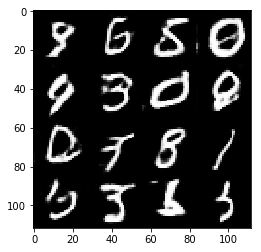

Epoch 2/2..., step 5200
 Time Taken for 100 steps : 6.00
 Discriminator Loss: 0.9827...
 Generator Loss: 2.9165



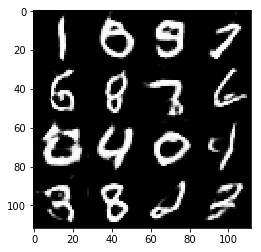

Epoch 2/2..., step 5300
 Time Taken for 100 steps : 6.04
 Discriminator Loss: 0.8288...
 Generator Loss: 0.9375



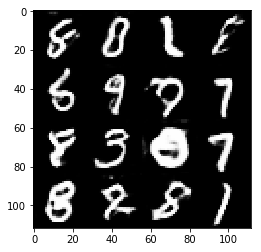

Epoch 2/2..., step 5400
 Time Taken for 100 steps : 6.14
 Discriminator Loss: 0.8051...
 Generator Loss: 1.2258



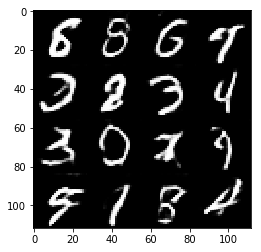

Epoch 2/2..., step 5500
 Time Taken for 100 steps : 6.56
 Discriminator Loss: 0.6505...
 Generator Loss: 2.8984



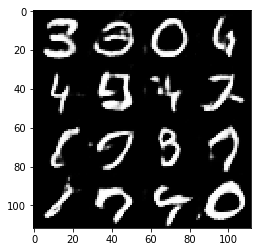

Epoch 2/2..., step 5600
 Time Taken for 100 steps : 6.30
 Discriminator Loss: 0.8920...
 Generator Loss: 2.1244



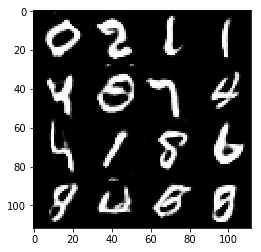

Epoch 2/2..., step 5700
 Time Taken for 100 steps : 6.29
 Discriminator Loss: 0.8999...
 Generator Loss: 1.7509



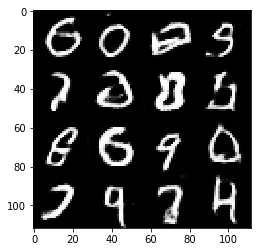

Epoch 2/2..., step 5800
 Time Taken for 100 steps : 6.25
 Discriminator Loss: 1.3242...
 Generator Loss: 0.8757



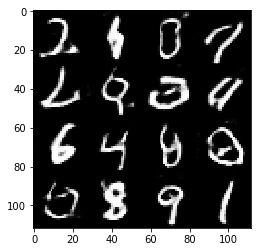

Epoch 2/2..., step 5900
 Time Taken for 100 steps : 6.37
 Discriminator Loss: 0.7527...
 Generator Loss: 1.9517



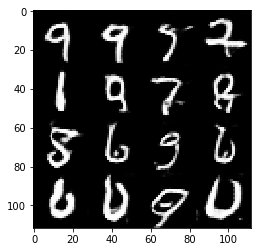

Epoch 2/2..., step 6000
 Time Taken for 100 steps : 6.19
 Discriminator Loss: 1.3620...
 Generator Loss: 0.6357



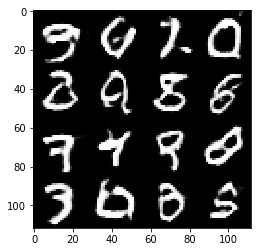

Epoch 2/2..., step 6100
 Time Taken for 100 steps : 6.51
 Discriminator Loss: 0.7704...
 Generator Loss: 2.5298



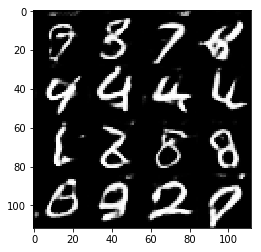

Epoch 2/2..., step 6200
 Time Taken for 100 steps : 6.05
 Discriminator Loss: 0.8264...
 Generator Loss: 2.2785



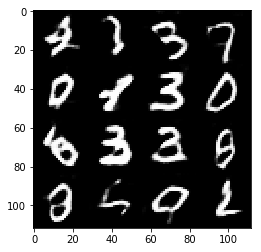

Epoch 2/2..., step 6300
 Time Taken for 100 steps : 6.14
 Discriminator Loss: 0.8258...
 Generator Loss: 2.6499



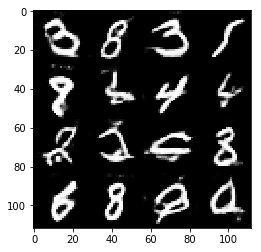

Epoch 2/2..., step 6400
 Time Taken for 100 steps : 6.09
 Discriminator Loss: 0.9328...
 Generator Loss: 2.6851



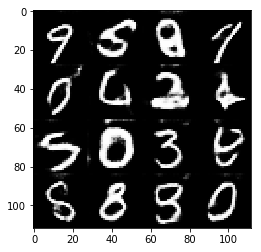

Epoch 2/2..., step 6500
 Time Taken for 100 steps : 6.22
 Discriminator Loss: 0.7153...
 Generator Loss: 1.9448



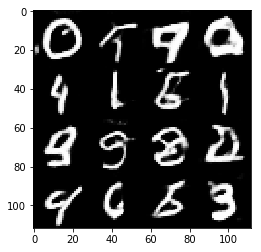

Epoch 2/2..., step 6600
 Time Taken for 100 steps : 6.21
 Discriminator Loss: 0.6945...
 Generator Loss: 2.7893



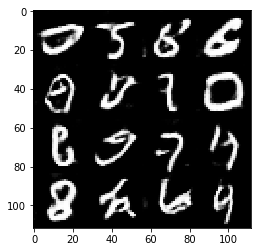

Epoch 2/2..., step 6700
 Time Taken for 100 steps : 6.29
 Discriminator Loss: 0.8209...
 Generator Loss: 3.1363



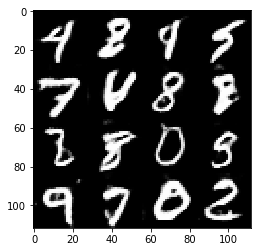

Epoch 2/2..., step 6800
 Time Taken for 100 steps : 6.40
 Discriminator Loss: 1.0185...
 Generator Loss: 3.2024



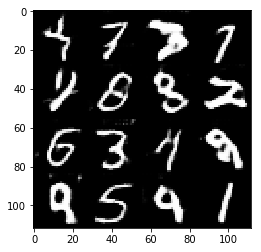

Epoch 2/2..., step 6900
 Time Taken for 100 steps : 6.28
 Discriminator Loss: 0.8435...
 Generator Loss: 1.7361



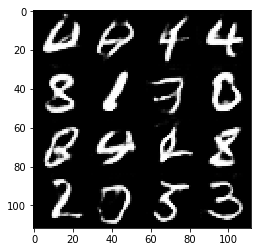

Epoch 2/2..., step 7000
 Time Taken for 100 steps : 6.34
 Discriminator Loss: 0.9918...
 Generator Loss: 1.5204



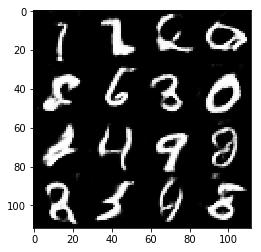

Epoch 2/2..., step 7100
 Time Taken for 100 steps : 6.30
 Discriminator Loss: 0.8116...
 Generator Loss: 1.6178



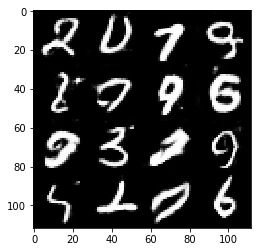

Epoch 2/2..., step 7200
 Time Taken for 100 steps : 6.29
 Discriminator Loss: 0.9509...
 Generator Loss: 1.8597



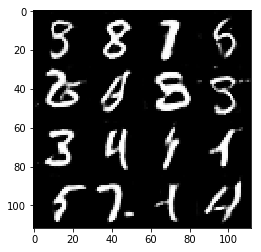

Epoch 2/2..., step 7300
 Time Taken for 100 steps : 6.36
 Discriminator Loss: 0.8105...
 Generator Loss: 2.2085



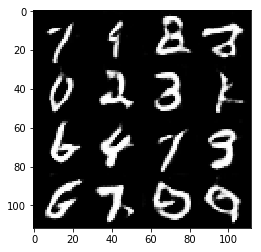

Epoch 2/2..., step 7400
 Time Taken for 100 steps : 6.26
 Discriminator Loss: 0.6807...
 Generator Loss: 1.7629



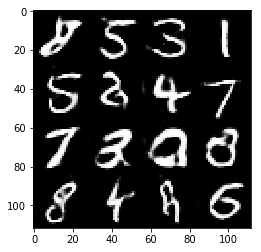

Epoch 2/2..., step 7500
 Time Taken for 100 steps : 5.96
 Discriminator Loss: 1.1323...
 Generator Loss: 1.1422



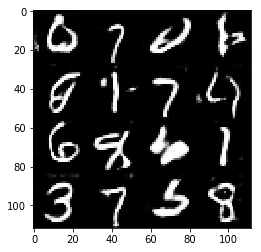

In [38]:
batch_size = 16
z_dim = 100
learning_rate = 0.0007

beta1 = 0.25
epochs = 2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
print("batch size : %s" %batch_size)
print("z_dim : %s" %z_dim)
print("learning_rate : %s" %learning_rate)
print("beta1 : %s" %beta1)

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

batch size : 64
z_dim : 100
learning_rate : 0.0002
beta1 : 0.25
Epoch 1/2..., step 100
 Time Taken for 100 steps : 20.35
 Discriminator Loss: 1.3509...
 Generator Loss: 1.2364



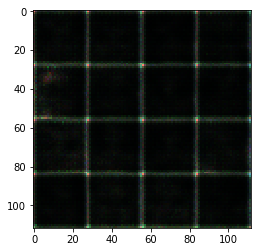

Epoch 1/2..., step 200
 Time Taken for 100 steps : 19.97
 Discriminator Loss: 0.6271...
 Generator Loss: 3.7950



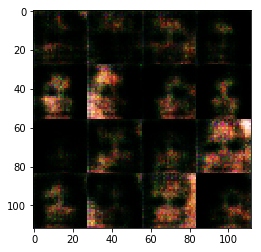

Epoch 1/2..., step 300
 Time Taken for 100 steps : 20.78
 Discriminator Loss: 0.6208...
 Generator Loss: 3.6322



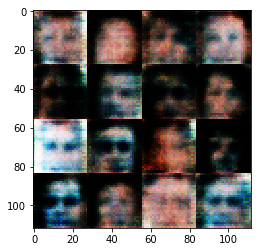

Epoch 1/2..., step 400
 Time Taken for 100 steps : 20.52
 Discriminator Loss: 0.7953...
 Generator Loss: 2.4452



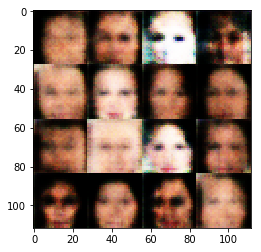

Epoch 1/2..., step 500
 Time Taken for 100 steps : 20.33
 Discriminator Loss: 0.8292...
 Generator Loss: 1.8728



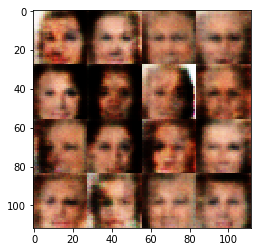

Epoch 1/2..., step 600
 Time Taken for 100 steps : 19.98
 Discriminator Loss: 0.8075...
 Generator Loss: 2.5958



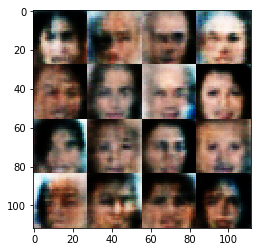

Epoch 1/2..., step 700
 Time Taken for 100 steps : 19.94
 Discriminator Loss: 0.8891...
 Generator Loss: 1.8494



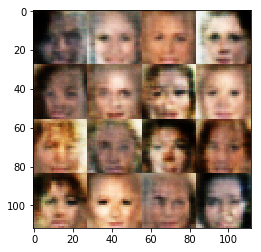

Epoch 1/2..., step 800
 Time Taken for 100 steps : 20.09
 Discriminator Loss: 1.1033...
 Generator Loss: 2.1456



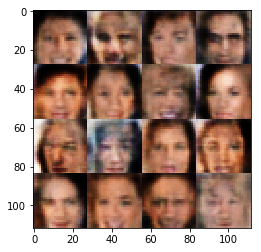

Epoch 1/2..., step 900
 Time Taken for 100 steps : 19.97
 Discriminator Loss: 1.0319...
 Generator Loss: 1.6604



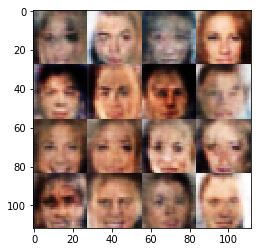

Epoch 1/2..., step 1000
 Time Taken for 100 steps : 20.47
 Discriminator Loss: 1.2492...
 Generator Loss: 1.0401



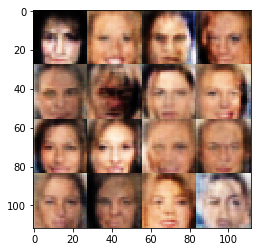

Epoch 1/2..., step 1100
 Time Taken for 100 steps : 20.65
 Discriminator Loss: 1.1164...
 Generator Loss: 1.0949



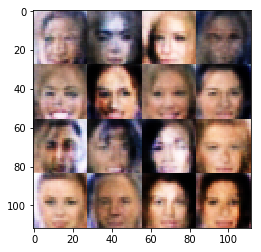

Epoch 1/2..., step 1200
 Time Taken for 100 steps : 20.42
 Discriminator Loss: 1.4053...
 Generator Loss: 0.6592



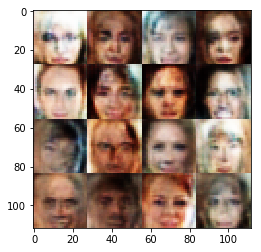

Epoch 1/2..., step 1300
 Time Taken for 100 steps : 20.49
 Discriminator Loss: 1.0617...
 Generator Loss: 1.6092



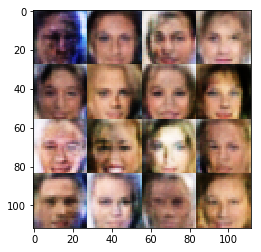

Epoch 1/2..., step 1400
 Time Taken for 100 steps : 20.52
 Discriminator Loss: 1.0554...
 Generator Loss: 2.1118



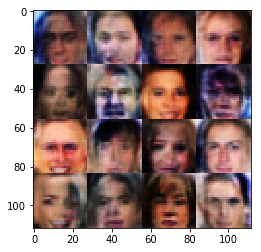

Epoch 1/2..., step 1500
 Time Taken for 100 steps : 20.27
 Discriminator Loss: 1.1319...
 Generator Loss: 0.9433



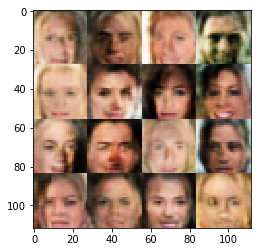

Epoch 1/2..., step 1600
 Time Taken for 100 steps : 20.81
 Discriminator Loss: 1.0203...
 Generator Loss: 1.6818



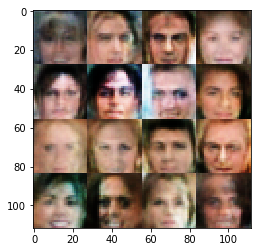

Epoch 1/2..., step 1700
 Time Taken for 100 steps : 20.77
 Discriminator Loss: 1.1100...
 Generator Loss: 1.3803



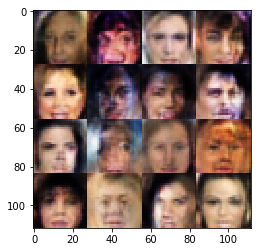

Epoch 1/2..., step 1800
 Time Taken for 100 steps : 20.14
 Discriminator Loss: 1.0191...
 Generator Loss: 1.5271



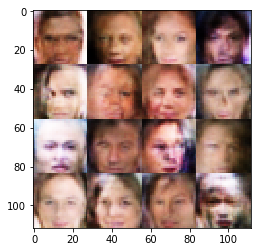

Epoch 1/2..., step 1900
 Time Taken for 100 steps : 20.36
 Discriminator Loss: 1.1804...
 Generator Loss: 0.9058



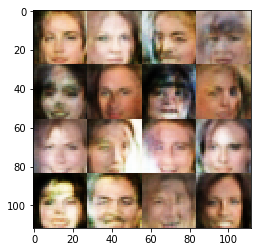

Epoch 1/2..., step 2000
 Time Taken for 100 steps : 20.27
 Discriminator Loss: 1.1674...
 Generator Loss: 1.7930



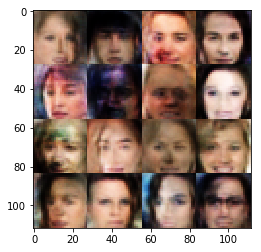

Epoch 1/2..., step 2100
 Time Taken for 100 steps : 20.30
 Discriminator Loss: 0.9707...
 Generator Loss: 1.3493



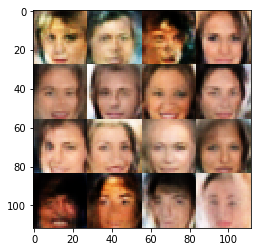

Epoch 1/2..., step 2200
 Time Taken for 100 steps : 20.47
 Discriminator Loss: 1.0526...
 Generator Loss: 1.1124



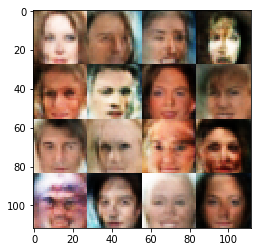

Epoch 1/2..., step 2300
 Time Taken for 100 steps : 19.98
 Discriminator Loss: 1.0728...
 Generator Loss: 1.1790



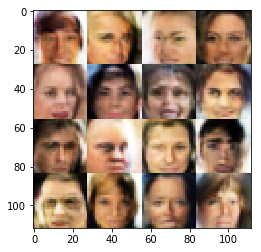

Epoch 1/2..., step 2400
 Time Taken for 100 steps : 19.98
 Discriminator Loss: 1.0616...
 Generator Loss: 1.1377



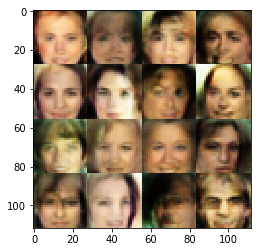

Epoch 1/2..., step 2500
 Time Taken for 100 steps : 20.39
 Discriminator Loss: 1.2785...
 Generator Loss: 0.9027



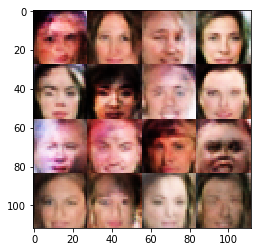

Epoch 1/2..., step 2600
 Time Taken for 100 steps : 20.49
 Discriminator Loss: 1.0720...
 Generator Loss: 1.1087



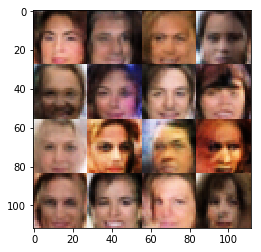

Epoch 1/2..., step 2700
 Time Taken for 100 steps : 20.52
 Discriminator Loss: 1.0886...
 Generator Loss: 1.7233



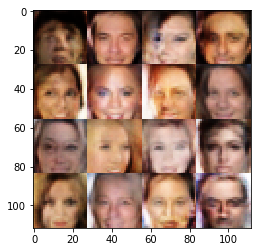

Epoch 1/2..., step 2800
 Time Taken for 100 steps : 20.25
 Discriminator Loss: 1.0229...
 Generator Loss: 1.0765



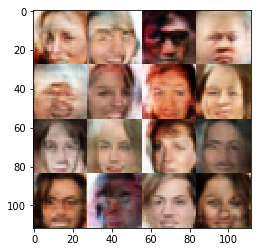

Epoch 1/2..., step 2900
 Time Taken for 100 steps : 20.30
 Discriminator Loss: 1.0603...
 Generator Loss: 1.1701



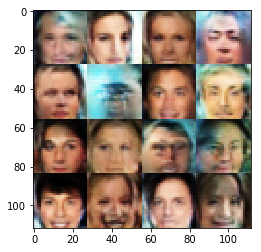

Epoch 1/2..., step 3000
 Time Taken for 100 steps : 20.07
 Discriminator Loss: 1.0966...
 Generator Loss: 1.2060



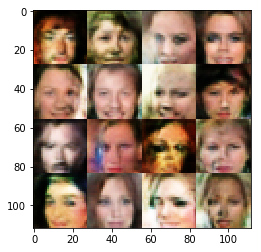

Epoch 1/2..., step 3100
 Time Taken for 100 steps : 20.29
 Discriminator Loss: 1.0941...
 Generator Loss: 2.2692



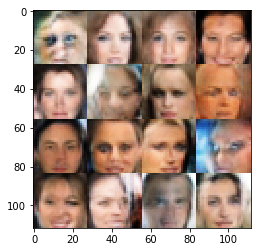

Epoch 2/2..., step 3200
 Time Taken for 100 steps : 20.87
 Discriminator Loss: 0.9618...
 Generator Loss: 1.4721



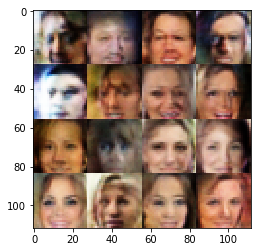

Epoch 2/2..., step 3300
 Time Taken for 100 steps : 20.25
 Discriminator Loss: 1.0405...
 Generator Loss: 0.9159



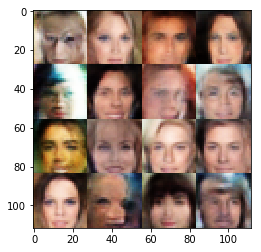

Epoch 2/2..., step 3400
 Time Taken for 100 steps : 20.81
 Discriminator Loss: 2.1279...
 Generator Loss: 0.3728



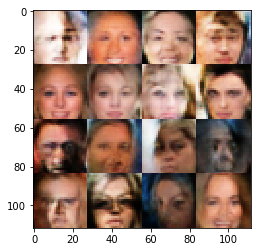

Epoch 2/2..., step 3500
 Time Taken for 100 steps : 20.48
 Discriminator Loss: 1.1419...
 Generator Loss: 0.9441



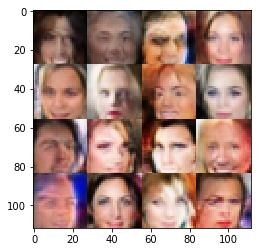

Epoch 2/2..., step 3600
 Time Taken for 100 steps : 20.59
 Discriminator Loss: 1.1707...
 Generator Loss: 0.9244



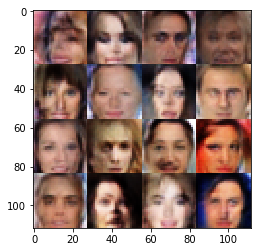

Epoch 2/2..., step 3700
 Time Taken for 100 steps : 20.54
 Discriminator Loss: 1.2410...
 Generator Loss: 0.9666



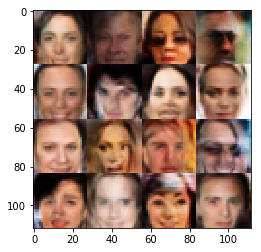

Epoch 2/2..., step 3800
 Time Taken for 100 steps : 20.26
 Discriminator Loss: 1.0623...
 Generator Loss: 1.1997



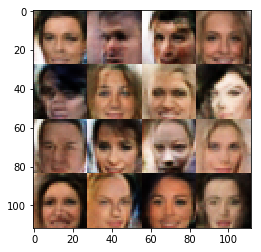

Epoch 2/2..., step 3900
 Time Taken for 100 steps : 20.03
 Discriminator Loss: 1.1451...
 Generator Loss: 1.3972



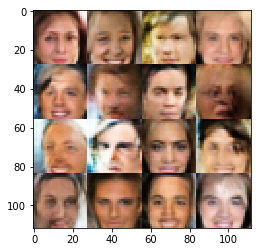

Epoch 2/2..., step 4000
 Time Taken for 100 steps : 20.02
 Discriminator Loss: 0.9782...
 Generator Loss: 1.2643



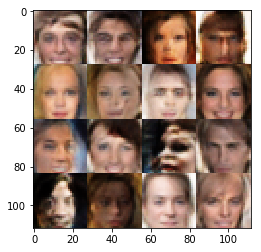

Epoch 2/2..., step 4100
 Time Taken for 100 steps : 19.99
 Discriminator Loss: 1.1577...
 Generator Loss: 0.8726



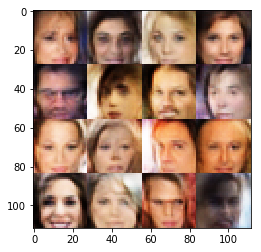

Epoch 2/2..., step 4200
 Time Taken for 100 steps : 20.40
 Discriminator Loss: 1.1755...
 Generator Loss: 1.0468



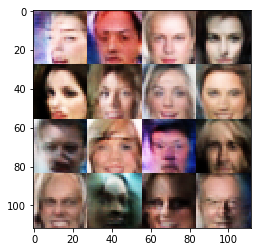

Epoch 2/2..., step 4300
 Time Taken for 100 steps : 20.05
 Discriminator Loss: 1.0149...
 Generator Loss: 1.1837



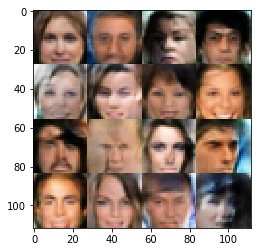

Epoch 2/2..., step 4400
 Time Taken for 100 steps : 20.29
 Discriminator Loss: 1.1122...
 Generator Loss: 1.5057



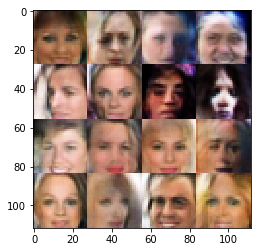

Epoch 2/2..., step 4500
 Time Taken for 100 steps : 20.23
 Discriminator Loss: 1.0522...
 Generator Loss: 1.5047



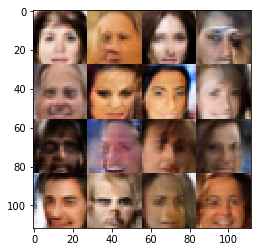

Epoch 2/2..., step 4600
 Time Taken for 100 steps : 20.04
 Discriminator Loss: 0.9379...
 Generator Loss: 1.5239



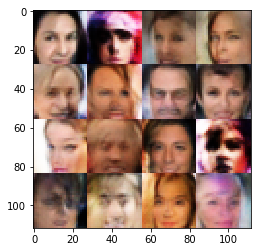

Epoch 2/2..., step 4700
 Time Taken for 100 steps : 19.97
 Discriminator Loss: 1.1928...
 Generator Loss: 0.9072



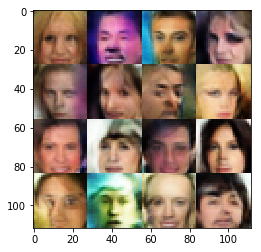

Epoch 2/2..., step 4800
 Time Taken for 100 steps : 19.95
 Discriminator Loss: 1.1404...
 Generator Loss: 2.0289



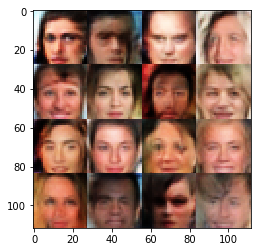

Epoch 2/2..., step 4900
 Time Taken for 100 steps : 19.97
 Discriminator Loss: 1.1758...
 Generator Loss: 0.9067



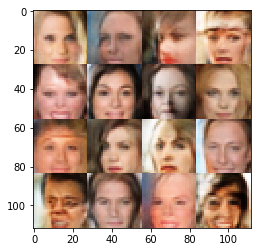

Epoch 2/2..., step 5000
 Time Taken for 100 steps : 19.98
 Discriminator Loss: 1.2538...
 Generator Loss: 1.7814



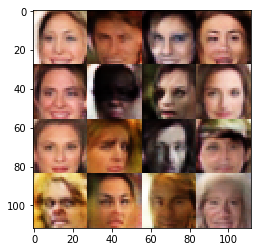

Epoch 2/2..., step 5100
 Time Taken for 100 steps : 19.95
 Discriminator Loss: 1.2011...
 Generator Loss: 1.6286



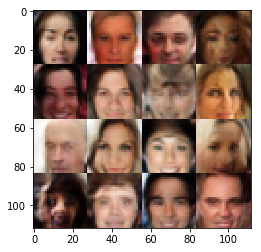

Epoch 2/2..., step 5200
 Time Taken for 100 steps : 19.91
 Discriminator Loss: 1.1169...
 Generator Loss: 1.9553



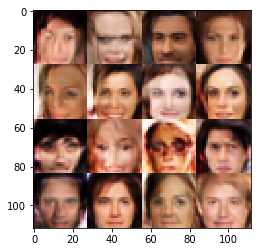

Epoch 2/2..., step 5300
 Time Taken for 100 steps : 20.00
 Discriminator Loss: 1.0026...
 Generator Loss: 1.5131



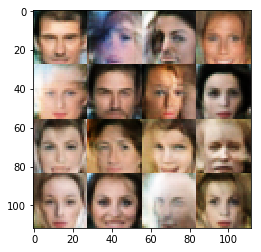

Epoch 2/2..., step 5400
 Time Taken for 100 steps : 19.96
 Discriminator Loss: 1.0638...
 Generator Loss: 1.1565



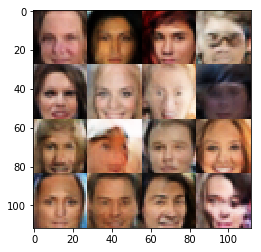

Epoch 2/2..., step 5500
 Time Taken for 100 steps : 20.58
 Discriminator Loss: 1.2729...
 Generator Loss: 1.9676



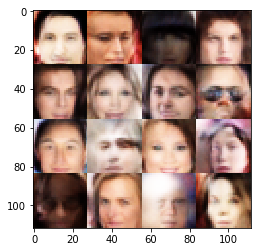

Epoch 2/2..., step 5600
 Time Taken for 100 steps : 20.35
 Discriminator Loss: 1.3028...
 Generator Loss: 0.8885



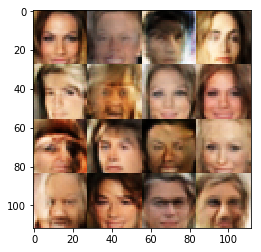

Epoch 2/2..., step 5700
 Time Taken for 100 steps : 20.16
 Discriminator Loss: 1.1320...
 Generator Loss: 1.2871



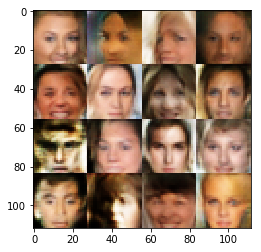

Epoch 2/2..., step 5800
 Time Taken for 100 steps : 20.19
 Discriminator Loss: 1.3799...
 Generator Loss: 0.6631



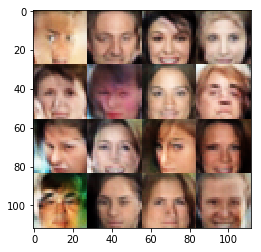

Epoch 2/2..., step 5900
 Time Taken for 100 steps : 20.06
 Discriminator Loss: 1.2556...
 Generator Loss: 1.0132



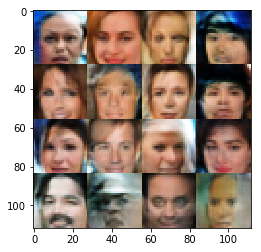

Epoch 2/2..., step 6000
 Time Taken for 100 steps : 20.22
 Discriminator Loss: 1.4006...
 Generator Loss: 0.6952



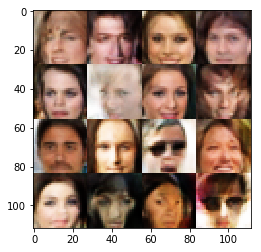

Epoch 2/2..., step 6100
 Time Taken for 100 steps : 20.66
 Discriminator Loss: 1.2769...
 Generator Loss: 0.7609



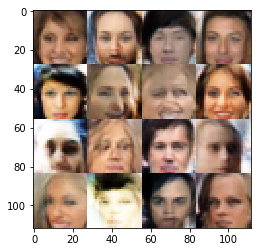

Epoch 2/2..., step 6200
 Time Taken for 100 steps : 20.25
 Discriminator Loss: 0.9652...
 Generator Loss: 1.4065



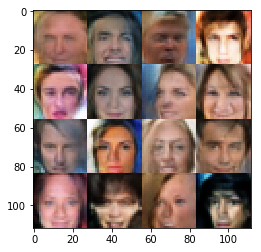

Epoch 2/2..., step 6300
 Time Taken for 100 steps : 20.34
 Discriminator Loss: 1.0551...
 Generator Loss: 1.1728



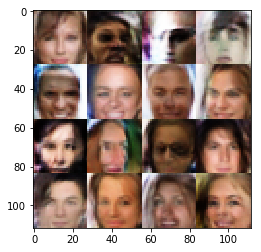

In [37]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002

beta1 = 0.25
epochs = 2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
print("batch size : %s" %batch_size)
print("z_dim : %s" %z_dim)
print("learning_rate : %s" %learning_rate)
print("beta1 : %s" %beta1)

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim,learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.